In [59]:
'''
    VisualizeConvnetFiltersVGG16
'''

from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights = 'imagenet',
           include_top = False)

layer_name = 'block3_conv1'
filter_index = 5
layer_ouput = model.get_layer(layer_name).output
print('layer_ouput.shape: ', layer_ouput.shape)

loss = K.mean(layer_ouput[:, :, :, filter_index])

print('loss.shape: ', loss.shape)
model.summary()

layer_ouput.shape:  (?, ?, ?, 256)
loss.shape:  ()
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D

In [ ]:
# This cell is just for testing portions of below algorithm.
# I think maybe grads is modifying the image to find the slope rather than 
# the usual trainging where modify the weights. 
grads = K.gradients(loss, model.input)[0]
print('gradients ', grads)
# Since we are working with tensors we need 
# to use keras backend math functions to operate on entire tensor object.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) 

iterate = K.function([model.input], [loss, grads])
import numpy as np
loss_value, grads_value = iterate([np.zeros((1,150, 150, 3))])
input_img_data = np.random.random((1,150, 150, 3))*20 +128.
step = 1
for i in range(40):
    loss_value, grad_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [74]:
iterate = K.function([model.input], [loss, grads])

input_img_data = np.random.random((1,150, 150, 3))*20 +128.
    
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x
 
    
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1,size, size, 3)) * 20 +128.
    step = 1
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)



(150, 150, 3)


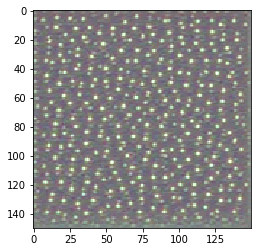

In [94]:
import matplotlib.pyplot as plt

y = generate_pattern('block3_conv1', 0)
''' y shape (150, 150, 3)
value:
y = 
[[[134 132 131]
  [133 135 132]
  [124 125 125]
  ...
  [125 129 124]
  [136 136 128]
  [124 127 127]]

 [[136 139 133]...
 
 So it seems that the gradients were of the same shape. Not sure
 if any convolution is applied during predict--this would reduce the dims.
 as layers are passed.  But predict ISN'T called only gradient with the loss
 function.  So it may just tweak each pixel of the image instead of tweaking
 the weights--then it finds the slope/gradient and applies it!
 ''' 
#print(y)
#print(y.shape)
plt.imshow(generate_pattern('block3_conv1', 0))


In [85]:

# This is hard-coded for a size 64 grid.  
# any more is like TMI
def create_layer_filter_grid_image(layer_name):
    size = 64
    margin = 5 # between tiles
    results = np.zeros((8* size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):
        for j in range(8):
            filter_img = generate_pattern(layer_name, i + (j * 8), size = size)

            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j* size + j* margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, 
                    vertical_start: vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)



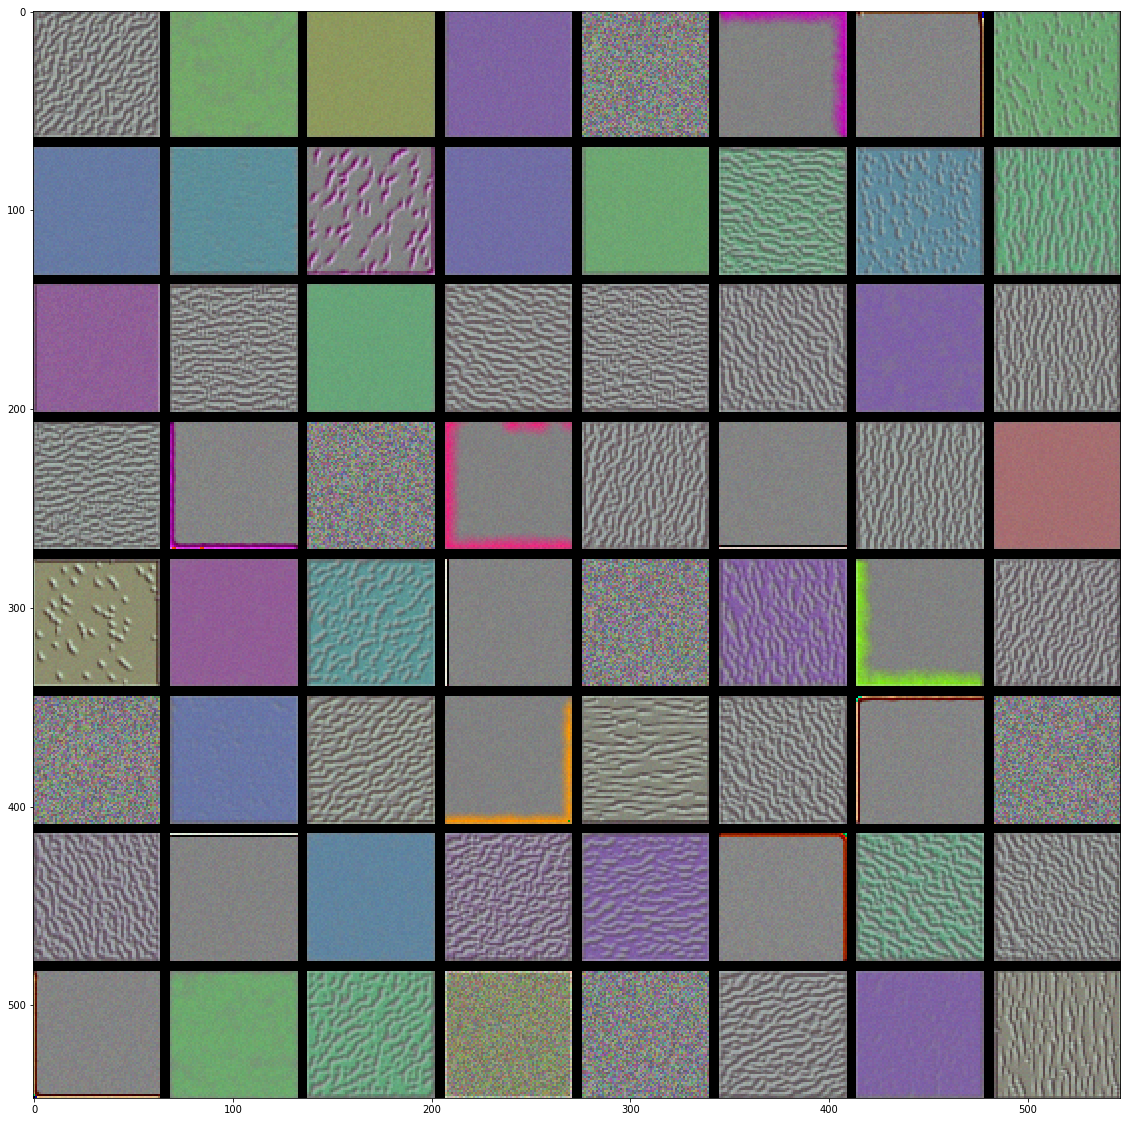

In [88]:
layer_name = 'block1_conv1'
#size = 64
create_layer_filter_grid_image(layer_name)

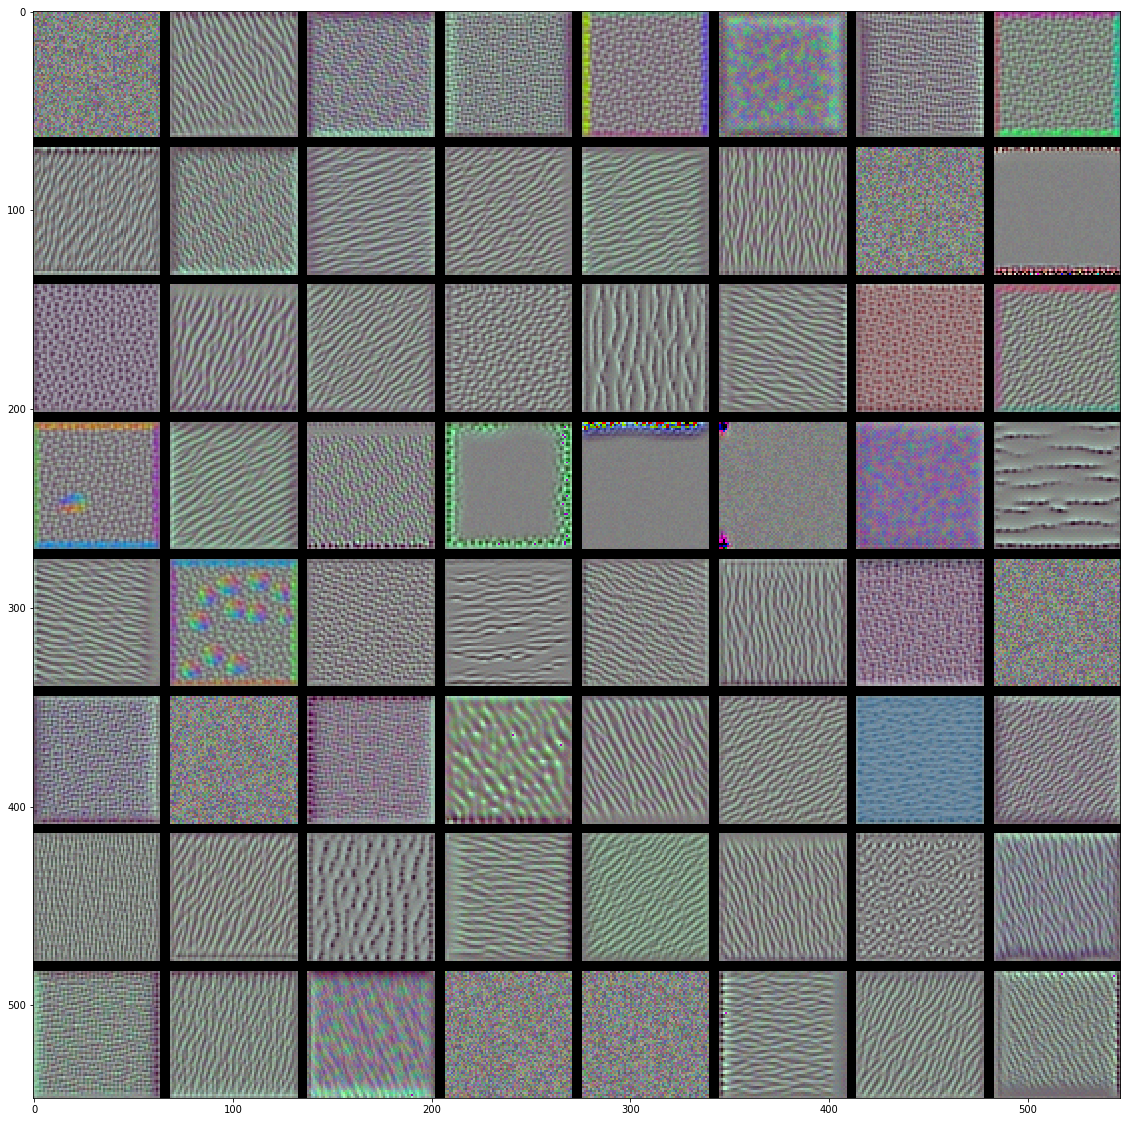

In [90]:
layer_name = 'block2_conv1'
#size = 64 # actually 128, but too detailed to see and need specialized grid for this
create_layer_filter_grid_image(layer_name)

Above filter started at 10:08.  Finished by 10:15--7 minutes, but it doesn't show all the filters anyway??  likely because I built-in and 8 x 8 grid--just do the 8 x 8 can't see much more realistically.

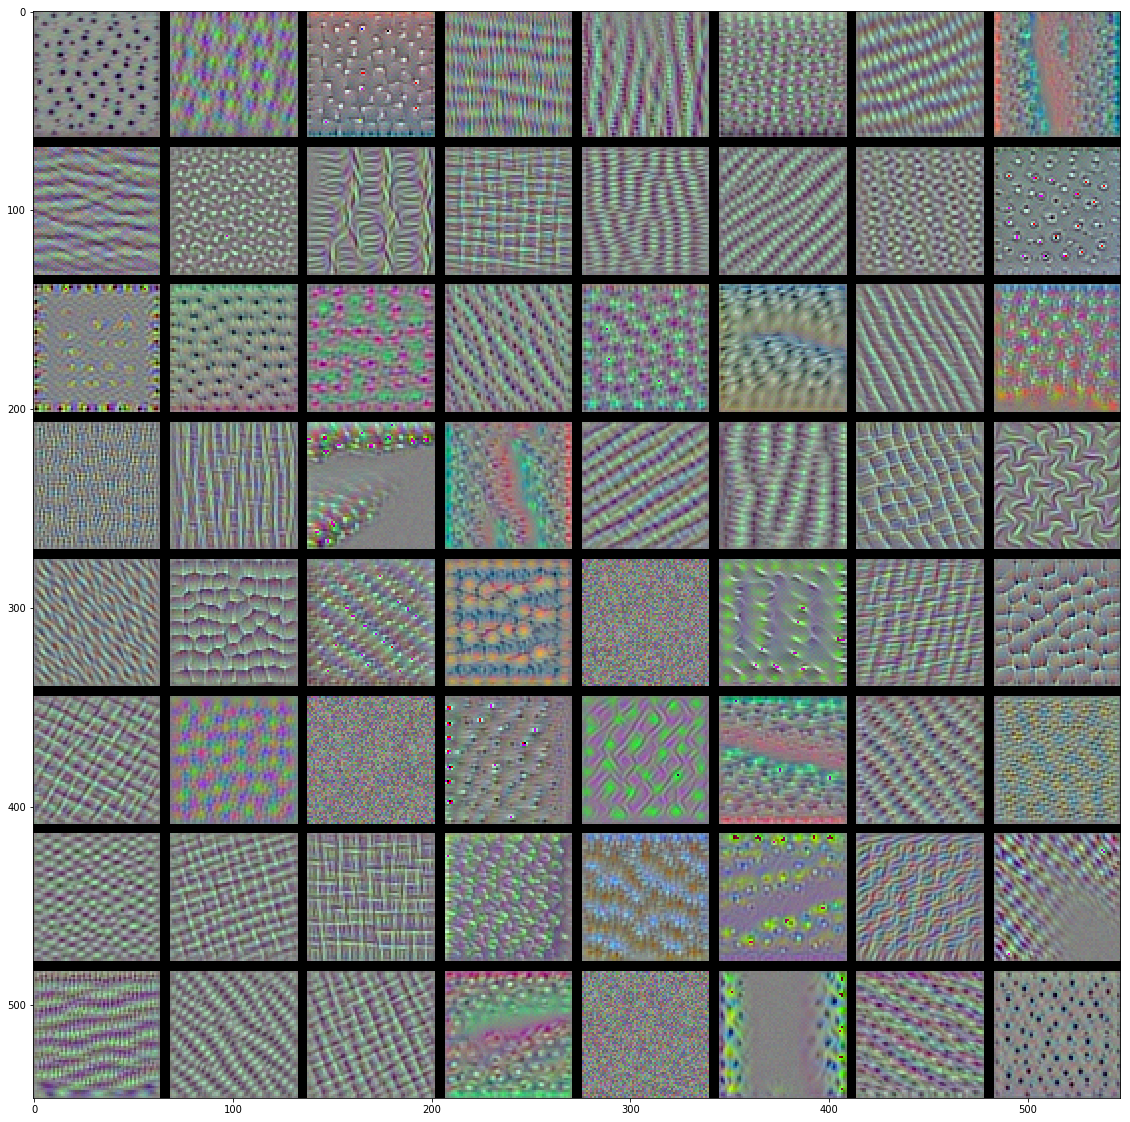

In [86]:
layer_name = 'block3_conv1'
create_layer_filter_grid_image(layer_name)

Above filter started at 10:28.  Finished by 10:31--3 minutes!

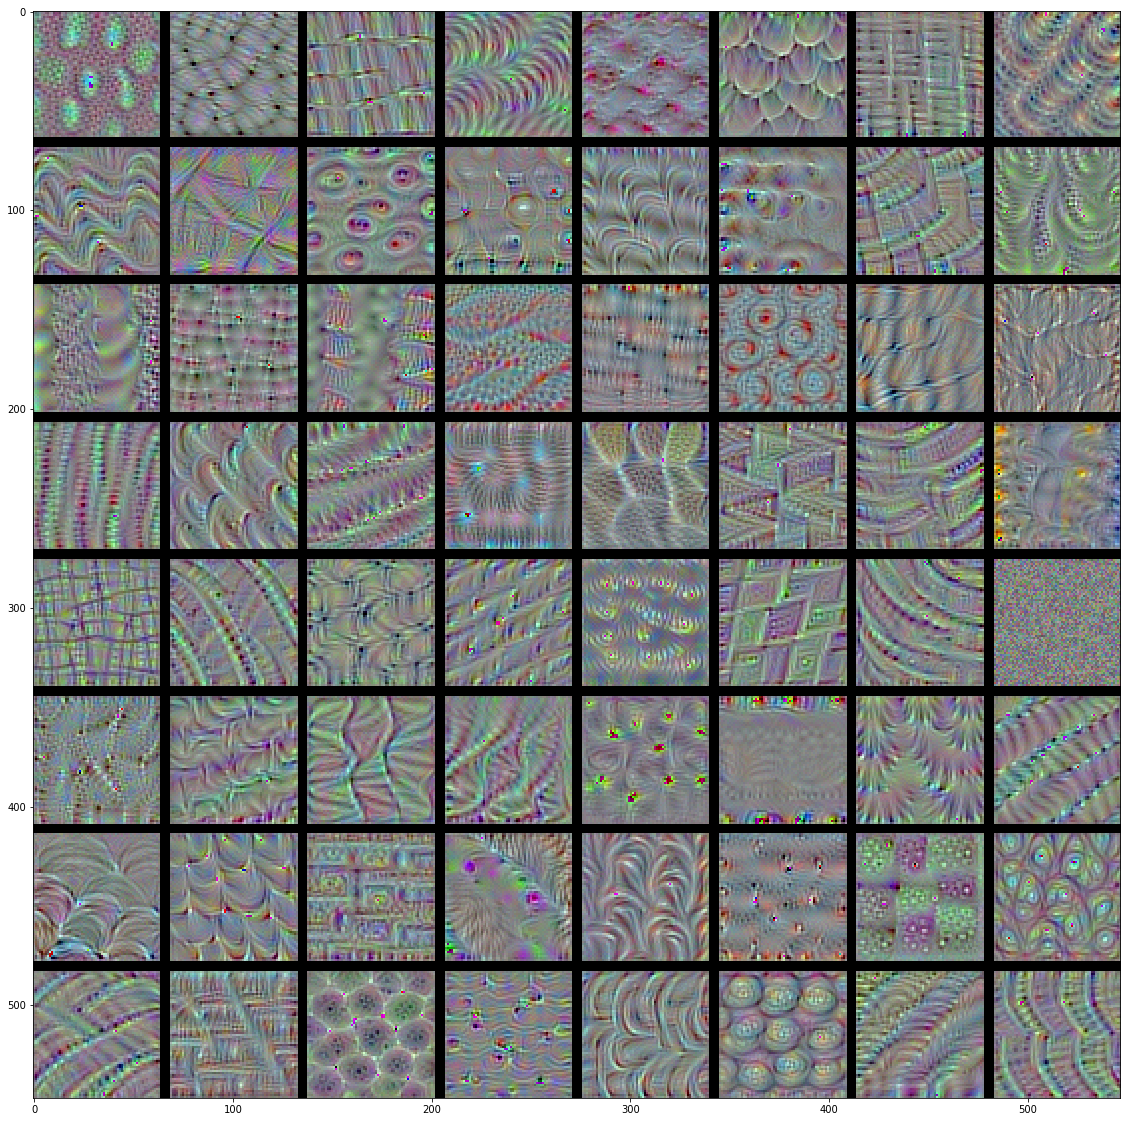

In [89]:
layer_name = 'block4_conv1'
# actual size = 512--showing only 64 of 'em!
create_layer_filter_grid_image(layer_name)